# Y-Shaped UMAP Classifier Tutorial
The y-shaped UMAP classifier is an extension of Parametric UMAP, which incorporates a second head, a classifier head, on the learned embedding. It is especially well suited for semi-supervised classification tasks, where a small labeled and a large unlabeled dataset is available. For a general tutorial on using the UMAP Classifier see the [UMAP Classifier Tutorial](01_umap_classifier.ipynb), or the Parametric UMAP Classifier see the [Parametric UMAP Classifier Tutorial](02_parametric_umap_classifier.ipynb).


>General network infrastructure of a y-shaped Parametric UMAP Classifier\
\
<img src=".figures/yumap.png" alt="Converted PDF" height="200">

In [ ]:
# imports
import sys
sys.path.insert(0, '../../')
import numpy as np
import joblib
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from helper_scripts import random_rm_trace_generator
from src.rm_classifier import yumap_classifier
from src.rm_classifier import performance_metrics as pm

In [2]:
# Load example data and split into training and test set
time_traces, spectra, phase, true_clusters, time_axis,freq_axis=random_rm_trace_generator.generate_random_rm_traces(
    400, n_clusters=5, outlier_fraction=0.05, noise_level=1)
time_traces, test_time_traces, spectra, test_spectra, phase, test_phase, true_clusters, test_true_clusters = train_test_split(
    time_traces, spectra, phase, true_clusters, test_size=0.5, random_state=42)

In [3]:
# initialize y-shaped parametric UMAP classifier
yu_clas = yumap_classifier.yUMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml")
prepared_data=yu_clas.prepare_data(time_traces, input_data_type="time",  data_preparation={'target_data_type': "fft"}, 
                 log_filter=True,avg_pooling=4,verbose=False,
                 normalization=True,
                 suppress_dc=True)

No rd_train_std provided. Calculating std from the provided prepared data.
No rd_train_std provided. Calculating std from the provided prepared data.


In [4]:
# the classifier head requires labeled samples for training
# However, it is also suited for semi-supervised training
# Here, we randomly select 20% of the samples to be labeled
n_data = prepared_data.shape[0]
n_labeled=int(0.2*n_data)
labeled_indices=np.random.choice(range(n_data), size=n_labeled, replace=False)
true_masked_clusters = np.copy(true_clusters)
true_masked_clusters[~labeled_indices]=-1 # set all non-labeled samples to -1


In [5]:
# apply keras_fit_kwargs such as early stopping or learning rate reduction on plateau
keras_fit_kwargs = {"callbacks": [
    keras.callbacks.EarlyStopping(
        monitor='val_classification_loss',
        min_delta=1e-4,
        patience=5,
        verbose=1,
        restore_best_weights=True,
        mode="min"

    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,                   # Reduce LR by half
    patience=2,                   # Wait 2 epochs before reducing
    min_lr=1e-7,                  # Don't go below this
    verbose=1
)
]}

In [ ]:
# Now we can train the yUMAP classifier
embeddings=yu_clas.train_embed(prepared_data, 
                         class_labels=true_masked_clusters, # class labels for the labeled samples, -1 for non-labeled samples
                         save_model="pumap_model", # path to save the model
                         parametric_reconstruction=True, # enable parametric reconstruction for validation
                         autoencoder_loss=True, # incorporate the autoencoder reconstruction loss into the total loss
                         parametric_reconstruction_loss_weight=2, # weight of the reconstruction loss in the total loss
                         n_training_epochs=50, # number of training epochs
                         batch_size=64, # batch size
                         val_train_split=0.1, # fraction of data to use for validation
                         loss_report_frequency=10, # frequency of loss reporting per epoch on the umap loss training of the encoder
                         keras_fit_kwargs=keras_fit_kwargs, # additional keras fit kwargs
                         verbose=False)

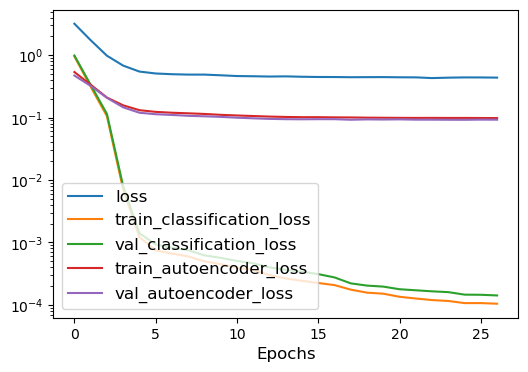

In [7]:
# plot the loss
plt.figure(figsize=(6,4))
history = joblib.load("../models/umap_classifier_1/pumap_model/history.pkl")
for key in history.keys():
    if key != "learning_rate":
        plt.plot(history[key], label=key)
plt.xlabel("Epochs", fontsize=12)
plt.legend(fontsize=12)
plt.yscale("log")
plt.show()


**Cluster Assertion**
> The clusters can be asserted in the same way as for UMAP or parametric UMAP by using DBSCAN/HDBSCAN. Another, inherent method is the use of the encoder/classifier, which was already trained. It incorporates the already learned clusters and can also be used for prediction of new data. 

Overriding db_min_samples with value 20 from kwargs.
Automatically determined db_eps: 0.8792114622609056 which is the 0.965 percentile of the 20-distance.


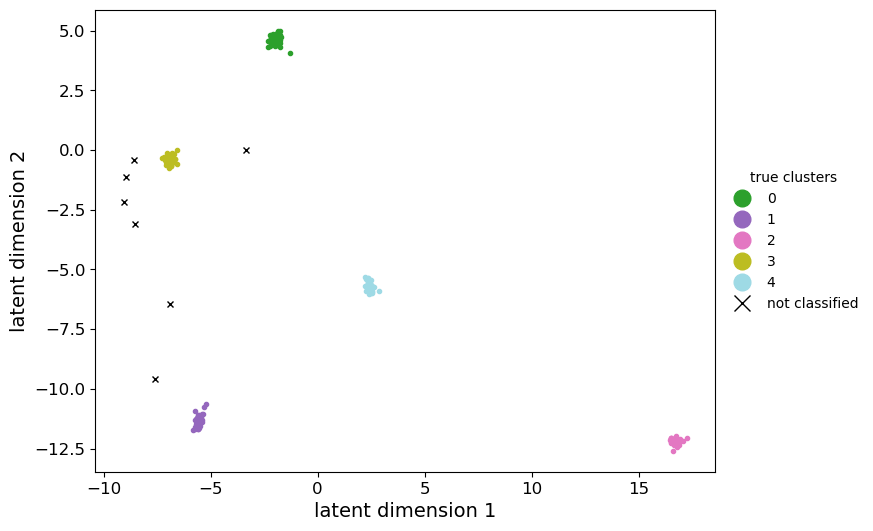

In [8]:
# Cluster identification with DBSCAN
db_clusters = yu_clas.db_classify(embeddings, verbose=True, db_min_samples=20, auto_eps=True)
fig, ax = yu_clas.plot_embedding(embeddings, labels=db_clusters, label_type='categorical', label_name="true clusters", alpha=1)

Processing batch 0 to 20000


Correctly classified 192/200 samples


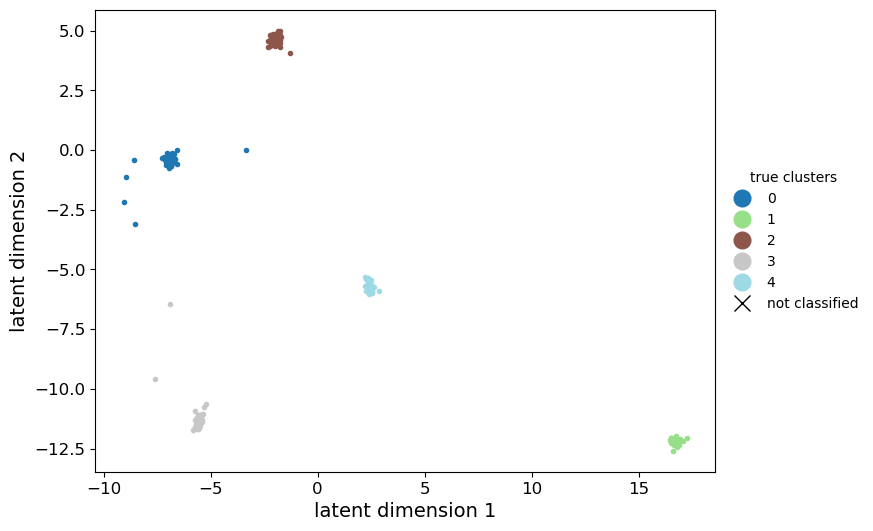

In [9]:
# Clusters identification with the classifier
embs, probs, clas_clusters = yu_clas.classify(prepared_data, verbose=True)
fig, ax = yu_clas.plot_embedding(embs, labels=clas_clusters, label_type='categorical', label_name="true clusters", alpha=1)
print(f"Correctly classified {sum(clas_clusters==true_clusters)}/{len(true_clusters)} samples")

**Predict Cluster Labels from New Data**
> We can apply the same visualization and prediction methods as for the [UMAP Classifier](umap_classifier.ipynb) in a similar manner. Furthermore, we can use the inherent prediction method, of using the learned classifier head of the y-shaped Parametric UMAP Classifier.

In [10]:
# Simple methods like uncorrelated Gaussian maximum likelihood classifier work similarly to the ones from the UMAP Classifier
yu_clas.prepare_ml_uncorrelated_normal_prediction(prepared_data, clas_clusters, verbose=True)
predictions, mls = yu_clas.ml_uncorrelated_normal_prediction(prepared_data, noise_alpha=0.9, min_logl=-10000)
print(sum(predictions == -1), "noise points detected among the training data by ML classifier")
print(f"{sum(predictions == clas_clusters)/len(predictions)*100:.3f}% of training data classified correctly by ML classifier")

Saved 5 cluster traces with mean statistic.
Saved 5 cluster traces with std statistic.
Calculating median uncorrelated normal likelihoods for each cluster.


8 noise points detected among the training data by ML classifier
96.000% of training data classified correctly by ML classifier


**ROC Curves for Outlier Detection**

In [11]:
# Create new data from a cluster not present in the training data
new_time_traces, new_spectra, new_phase, new_true_clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(
    50, n_clusters=1, outlier_fraction=1, noise_level=1)
new_true_clusters=np.repeat(-1, 50)  # Mark all new data as outliers
# Prepare the new data 
new_prepared_data=yu_clas.prepare_data(new_time_traces, verbose=False)
prepared_test_data=yu_clas.prepare_data(test_time_traces, verbose=False)

Using previous rd_train_mean and rd_train_std for normalization.
Using previous rd_train_mean and rd_train_std for normalization.


In [12]:
yu_clas.prepare_yumap_transform_prediction(prepared_data)

Preparing to transform data with Parametric UMAP model and predict clusters with DBSCAN
Processing batch 0 to 20000


In [13]:
%%capture output
# Predict the clusers by the classifier head.
# identify noise by high reconstruction loss with different values for noise_alpha
alphas = np.logspace(-2, 2, 1000)[::-1]
fprs, tprs = [], []

# Make the cluster assignment including the costly embedding and the calculation of reconstruction loss in advance
# Of course, one can also adjust the noise_alpha in each step, which would be computationally way more expensive
new_predictions, _, new_rec_loss, _ = yu_clas.yumap_transform_prediction(new_prepared_data, rec_loss_noise_detection=True, rec_loss_alpha=1e10)    
test_predictions, _, test_rec_loss, _ = yu_clas.yumap_transform_prediction(prepared_test_data,  rec_loss_noise_detection=True, rec_loss_alpha=1e10)

for alpha in alphas:

    new_predictions[new_rec_loss > (yu_clas.cluster_median_rec_loss[new_predictions] * alpha)] = -1
    test_predictions[test_rec_loss > (yu_clas.cluster_median_rec_loss[test_predictions] * alpha)] = -1
    true_noise_points = sum(new_predictions == -1)
    false_noise_points = sum(test_predictions == -1)
    tprs.append(true_noise_points/len(new_predictions))
    fprs.append(false_noise_points/len(test_predictions))

AUC: 0.9692


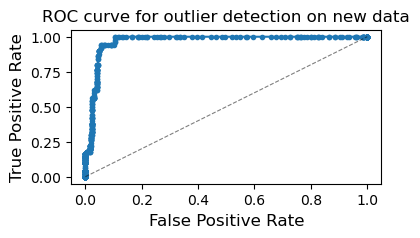

In [14]:
# Plot the ROC curve
plt.figure(figsize=(4,2))
plt.plot(fprs, tprs, ".-")
plt.plot([0,1], [0,1], "--", color="k", alpha=0.5, linewidth=0.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for outlier detection on new data')
print(f"AUC: {auc(fprs, tprs):.4f}")
plt.show()

In [15]:
#%%capture output
# Predict the clusers by the classifier head.
# Here, identify noise by low likelihood for being in a cluster.
# However, this method is not as reliable as the reconstruction loss based method, since the model learns to set the maximum likelihoods close to one.
alphas = np.logspace(-1, 1, 1000)
fprs, tprs = [], []

# Make the cluster assignment including the costly embedding and the calculation of likelihoods in advance
# Of course, one can also adjust the noise_alpha in each step, which would be computationally way more expensive
new_predictions, _, _, new_likelihoods = yu_clas.yumap_transform_prediction(new_prepared_data, class_loss_noise_detection=True,class_loss_alpha=0,class_loss_threshold=0)    
test_predictions, _, _, test_likelihoods = yu_clas.yumap_transform_prediction(prepared_test_data,  class_loss_noise_detection=True, class_loss_alpha=0,class_loss_threshold=0)
for alpha in alphas:

    new_predictions[new_likelihoods < (yu_clas.cluster_median_pred_likelihood[new_predictions] * alpha)] = -1
    test_predictions[test_likelihoods < (yu_clas.cluster_median_pred_likelihood[test_predictions] * alpha)] = -1
    true_noise_points = sum(new_predictions == -1)
    false_noise_points = sum(test_predictions == -1)
    tprs.append(true_noise_points/len(new_predictions))
    fprs.append(false_noise_points/len(test_predictions))

Processing batch 0 to 20000
Calculating classification likelihood for outlier detection
Processing batch 0 to 20000
Calculating classification likelihood for outlier detection


AUC: 0.7186


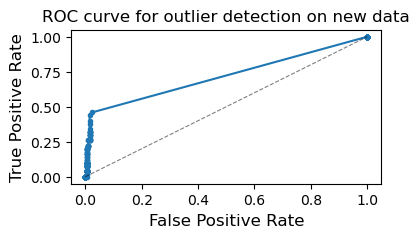

In [16]:
# Plot the ROC curve
plt.figure(figsize=(4,2))
plt.plot(fprs, tprs, ".-")
plt.plot([0,1], [0,1], "--", color="k", alpha=0.5, linewidth=0.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for outlier detection on new data')
print(f"AUC: {auc(fprs, tprs):.4f}")
plt.show()